In [1]:
  
'''
Author: Eni Awowale
Date created: April 14, 2021
Last updated: July 20, 2021
Purpose:
Calculate the water yields and water yield gain potential for given raster (geo_tiff) filse.
Uses gdal, rasterio, and numpy libraries to calculate basal area
'''

#Libraries
import os, gdal, uuid
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
import sys
import math
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
#from rasterio import crs, transform, features
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.windows import Window
from rasterio.plot import show
import numpy as np
from osgeo import osr, gdal, gdal_array
from osgeo.gdalnumeric import *
import glob
#from gdalconst import *
#from osgeo.gdalconst import *

In [2]:
#change wd
os.chdir('C:/Users/oawowale/OneDrive - USDA/Geospatial Ecology Team/Water_Yields_Proj/')
#os.chdir('E:/eni_folder/Water_Yields_Proj/')

In [3]:
#List of GDAL data types
gdal_const_att_list = [gdalconst.GDT_Unknown, gdalconst.GDT_Byte, gdalconst.GDT_UInt16, gdalconst.GDT_Int16, gdalconst.GDT_UInt32,
                        gdalconst.GDT_Int32, gdalconst.GDT_Float32, gdalconst.GDT_Float64, gdalconst.GDT_CInt16,
gdalconst.GDT_CInt32, gdalconst.GDT_CFloat32, gdalconst.GDT_CFloat64]

In [4]:
'''
Converting file type functions:
Functions for converting from arrays, tifs and vrts. They all use a similar function call. Examples given below'''

'\nConverting file type functions:\nFunctions for converting from arrays, tifs and vrts. They all use a similar function call. Examples given below'

In [6]:
'''Enter the tif file name with the extensions and your desired filename for the vrt
For example:
convert_tif_to_vrt(raster_to_change.tif, filename_of_vrt_raster)
This will return a vrt to your file directory
'''

'Enter the tif file name with the extensions and your desired filename for the vrt\nFor example:\nconvert_tif_to_vrt(raster_to_change.tif, filename_of_vrt_raster)\nThis will return a vrt to your file directory\n'

In [5]:
#Convert tif to vrt
def convert_tif_to_vrt(tif_file_name, desired_filename):
    vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
    vrt_filename = desired_filename + '.vrt'
    vrt_ds = gdal.BuildVRT(vrt_filename, tif_file_name, options=vrt_options)
    vrt_ds = None

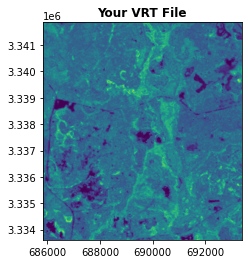

In [89]:
convert_tif_to_vrt('conversion/all_baa_snip.tif', 'conversion/all_baa_snip_for_vrt')
vrt_ds = rio.open('conversion/all_baa_snip_for_vrt.vrt')
show(vrt_ds, title='Your VRT File')
vrt_ds.close()

In [15]:
'''For using the tif to array function enter the band number you want to covert to an array when calling the function'''
'''Example: 

tif_to_array('sample_tif.tif', 1)

'''

"Example: \n\ntif_to_array('sample_tif.tif', 1)\n\n"

In [18]:
# Returns array given a geotif file and band number
def tif_to_array(raster_filename, band_num):
    tif_ds = gdal.Open(raster_filename)
    tif_ds_band = tif_ds.GetRasterBand(band_num)
    no_data_value = tif_ds_band.GetNoDataValue()
    numpy_array = BandReadAsArray(tif_ds_band)
    numpy_array = numpy_array.astype('float')
    numpy_array[numpy_array == no_data_value] = np.nan
    return numpy_array

In [19]:
sample_array = tif_to_array('conversion/all_baa_snip.tif', 1)
sample_array

array([[123., 124., 109., ...,  77.,  49.,  42.],
       [113., 113., 110., ...,  84.,  72.,  44.],
       [115., 120., 117., ...,  77.,  76.,  61.],
       ...,
       [ 84.,  83.,  82., ...,  85.,  74.,  67.],
       [ 81.,  82.,  80., ...,  79.,  75.,  68.],
       [ 84.,  84.,  83., ...,  80.,  75.,  74.]])

In [ ]:
'''The array to tif function you use a reference raster for projection and extent (geotransform)'''
'''Example:
array_to_tif(sample_array, sample_out_tif, reference_projection.tif)
'''

In [20]:
# Returns a geotiff file given a numpy array and reference raster
def array_to_tif(numpy_array, desired_filename, reference_projection_raster):
    y, x = numpy_array.shape #getting the height and width of rasters it's backwards for numpy y is rows x is columns
    tif_out_filename = desired_filename + '.tif'
    dtype = gdal_array.NumericTypeCodeToGDALTypeCode(numpy_array.dtype) #data type of the numpy array
    ref_ras_ds = gdal.Open(reference_projection_raster)
    #creating new geotiff
    tif_out = gdal.GetDriverByName('GTiff').Create(tif_out_filename, x, y, 1, gdal_const_att_list[dtype])
    tif_out.SetGeoTransform(ref_ras_ds.GetGeoTransform())
    tif_out.SetProjection(ref_ras_ds.GetProjection())
    tif_out.GetRasterBand(1).WriteArray(numpy_array)
    tif_out = None
    ref_ras_ds = None

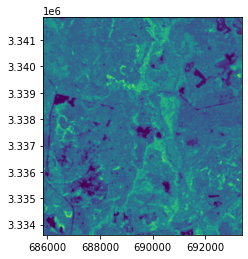

In [88]:
array_to_tif(sample_array, 'conversion/sample_array_to_tif', 'conversion/all_baa_snip.tif')
with rio.open('conversion/sample_array_to_tif.tif') as src:
    show(src)

In [22]:
#Converts an array to a tif file using rasterio, returns geotif
#Requires more input parameters than the array to tif function above using gdal, but can be useful
def array_to_tif_rio(numpy_array, extent_agg_raster, desired_filename, ref_raster):
    ref_raster_ds = rio.open(ref_raster)
    tif_out_filename = desired_filename + '.tif'
    aggregate_raster_ds = rio.open(tif_out_filename, 'w',
                                   driver='GTiff',
                                   height=numpy_array.shape[0],
                                   width=numpy_array.shape[1],
                                   count=1,
                                   dtype=numpy_array.dtype,
                                   crs=ref_raster_ds.crs,
                                   transform=extent_agg_raster)
    aggregate_raster_ds.write(numpy_array, 1)
    aggregate_raster_ds.close()
    ref_raster_ds.close()

In [ ]:
#Functions for manipulating raster nodata values

In [34]:
#Sets the nodata value of a raster'''
def set_nodata_value_of_raster(raster_file_name, band_num, desired_no_data_value):
    raster_file_ds = gdal.Open(raster_file_name, gdal.GA_Update)
    raster_file_ds.GetRasterBand(band_num).SetNoDataValue(desired_no_data_value)
    raster_file_ds = None

In [47]:
set_nodata_value_of_raster('nodata/pine_10m_agg_clip.tif', 1, 255)
with rio.open('nodata/pine_10m_agg_clip.tif') as src:
    print(src.nodata)

255.0


In [48]:
#Changes nodata value from np.nan to a desired interger nodata value
def np_nan_to_nodata_val(numpy_array, desired_no_data_val):
    numpy_array[np.isnan(numpy_array)] = desired_no_data_val
    new_array = numpy_array.astype('int')
    return new_array

In [49]:
#Changes interger nodata value to np.nan'''
def nodata_val_to_np_nan(raster_filename, band_num):
    raster_ds = gdal.Open(raster_filename, gdal.GA_Update)
    arr_to_update = tif_to_array(raster_filename, band_num)

    if raster_ds.GetRasterBand(band_num).GetNoDataValue() is None:
        print('You need to set a no data value for your raster. Use the set_no_data_value function')
    else:
        no_data_val = raster_ds.GetRasterBand(band_num).GetNoDataValue()
        arr_to_update = arr_to_update.astype('float')
        arr_to_update[arr_to_update == no_data_val] = np.nan
        return arr_to_update
    raster_ds = None

In [53]:
new_array_with_nan = nodata_val_to_np_nan('nodata/pine_10m_agg_clip.tif', 1)
np.isnan(new_array_with_nan)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
'''
Raster Pre-processing functions:
Functions used to pre-process rasters so they can be used for numpy array math
'''

In [66]:
#Function for converting raster from feet per acre to meters per hectare
def convert_sqhma(raster_to_convert_filename, band_num, desired_filename): #returns coverted raster
    raster = gdal.Open(raster_to_convert_filename)
    band = raster.GetRasterBand(band_num)
    data_type = band.DataType
    raster_ds = gdal.Open(raster_to_convert_filename, gdal_const_att_list[data_type])
    raster_ds_geotrans = raster_ds.GetGeoTransform()
    raster_ds_proj = raster_ds.GetProjection()
    wide = raster_ds.RasterXSize
    high = raster_ds.RasterYSize
    #read band as array
    raster_arr = BandReadAsArray(band)
    raster_arr_sqhma = (raster_arr * 0.229568411)
    dtype_numpy = gdal_array.NumericTypeCodeToGDALTypeCode(raster_arr_sqhma.dtype)
    raster_out_name = desired_filename + '.tif'
    raster_sqhma_ds = gdal.GetDriverByName('GTiff').Create(raster_out_name, wide, high, band_num, gdal_const_att_list[dtype_numpy])
    raster_sqhma_ds.SetGeoTransform(raster_ds_geotrans)
    raster_sqhma_ds.SetProjection(raster_ds_proj)
    raster_sqhma_ds.GetRasterBand(band_num).WriteArray(raster_arr_sqhma)
    raster_sqhma_ds.FlushCache()

In [67]:
#Returns array and transform values
#Aggregate rasters based on a given ref_raster shape.
def aggregate_raster(raster_to_aggregate, up_down_factor, band_num):
    raster_to_aggregate_ds = rio.open(raster_to_aggregate)
    nodata_val = raster_to_aggregate_ds.nodata
    raster_to_aggregate_data = raster_to_aggregate_ds.read(band_num,
                                                           out_shape=(int(raster_to_aggregate_ds.height * up_down_factor), int(raster_to_aggregate_ds.width * up_down_factor)),
                                                           resampling=Resampling.nearest)
    raster_to_aggregate_data = raster_to_aggregate_data.astype('float32')
    #set nodata value to np nan
    raster_to_aggregate_data[raster_to_aggregate_data == nodata_val] = np.nan
    transform = raster_to_aggregate_ds.transform * raster_to_aggregate_ds.transform.scale(
        (int(raster_to_aggregate_ds.width / raster_to_aggregate_data.shape[-1])),
        (int(raster_to_aggregate_ds.height / raster_to_aggregate_data.shape[-2])))
    raster_to_aggregate_ds.close()
    return raster_to_aggregate_data, transform

In [77]:
pine_5m_to_10m, transform = aggregate_raster('preprocess/5m_pine_perc_fin_snip.tif', .5, 1)
array_to_tif_rio(pine_5m_to_10m, transform, 'preprocess/pine_10m_agg', 'preprocess/5m_pine_perc_fin_snip.tif')

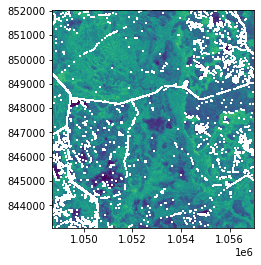

In [78]:
with rio.open('preprocess/pine_10m_agg.tif') as src:
    show(src)

In [95]:
#Reprojects and transforms given raster to the crs and geotransform of the reference raster using rasterios reproject functions
# UPDATES the raster_to_change and returns an array'''
def reproject_and_transform(ref_raster, raster_to_change, band_num):
    #Opened and converted raster crs to parseable string for rio
    ref_raster_ds = rio.open(ref_raster)
    ref_raster_ds_crs = ref_raster_ds.crs
    dst_crs = ref_raster_ds_crs.to_string()
    ref_width = ref_raster_ds.width
    ref_height = ref_raster_ds.height
    ref_transform = ref_raster_ds.transform
    ref_raster_ds.close()
    raster_to_change_array = tif_to_array(raster_to_change, band_num)

    with rio.open(raster_to_change) as src:
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': ref_transform,
            'width': ref_width,
            'height': ref_height
        })
        #updates bounds to target crs, calculates resolution, and new transform
        #reproject raster
        with rio.open(raster_to_change, 'w', **kwargs) as dst:
            reproject(
                source=raster_to_change_array,
                destination=rio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
        #raster_to_change_array and changed_arr are different
        #changed arr has more or less raster cells that correspond to the new raster
        with rio.open(raster_to_change) as dataset:
            changed_arr = dataset.read(1)
            return changed_arr

In [99]:
with rio.open('preprocess/all_baa_snip.tif') as src:
    print(src.crs)

None


In [124]:
all_baa_repro_transf = reproject_and_transform('preprocess/pine_10m_agg.tif', 'preprocess/all_baa_snip.tif', 1)

In [125]:
with rio.open('preprocess/all_baa_snip.tif') as src:
    print(src.crs)

PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [126]:
#Reprojects and transforms rasters using gdal
#Less robust than reproject_and_transform but works fine
def match_rasters(ref_raster_filename, b1, raster_match_filename, desired_filename): #ref_raster is the raster that we want match_raster to completely match up to
    # Read get info from reference raster
    ref_ds = gdal.Open(ref_raster_filename)
    band = ref_ds.GetRasterBand(b1)
    no_data_val = band.GetNoDataValue()
    #data_type = band.DataType
    ref_geotrans = ref_ds.GetGeoTransform()
    ref_proj = ref_ds.GetProjection()
    wide = ref_ds.RasterXSize
    high = ref_ds.RasterYSize
    #Read get information from raster you want to change
    raster_match_ds = gdal.Open(raster_match_filename)
    #raster_match_ds_geotrans = raster_match_ds.GetGeoTransform()
    raster_match_proj = raster_match_ds.GetProjection()
    #Create new output raster that matches reference raster
    out_filename_str = desired_filename + '.tif'
    output_raster = gdal.GetDriverByName('GTiff').Create(out_filename_str, wide, high, b1)
    output_raster.SetGeoTransform(ref_geotrans)
    output_raster.SetProjection(ref_proj)
    gdal.ReprojectImage(raster_match_ds, output_raster, raster_match_proj, ref_proj)
    band_output_raster = output_raster.GetRasterBand(1)
    output_raster_array = BandReadAsArray(band_output_raster)
    del output_raster
    del ref_ds
    ref_ds = None
    band = None
    band_output_raster = None
    return output_raster_array

In [ ]:
'''Tiling, dividing, merging, and mosaicing raster functions for processing large rasters as subsets'''

In [104]:
# Divides a raster tif file raster subsets or smaller geotiff of given raster
# Enter the size x and y size of the desired raster subsets
# Allows for mosaicing and merging of raster subsets to a larger merged/mosaiced raster
#tile_raster('basal_arr_clip.tif', 'C:/Users/oawowale/Documents/landcover/','C:/Users/oawowale/Documents/landcover/tiles/', 1000, 1000)
def tile_raster(raster_to_tile, in_path_name, out_path_name, tile_size_x, tile_size_y):
    in_path = in_path_name
    out_path = out_path_name
    output_filename = 'tile_'
    raster_in_ds = gdal.Open(raster_to_tile)
    if raster_in_ds.RasterCount == 1:
        band_num = 1
        band_raster_in_ds = raster_in_ds.GetRasterBand(band_num)
        xsize = band_raster_in_ds.XSize
        ysize = band_raster_in_ds.YSize
        for i in range(0, xsize, tile_size_x):
            for j in range(0, ysize, tile_size_y):
                com_string = "gdal_translate -of GTIFF -srcwin " + str(i) + ", " + str(j) + ", " \
                             + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(in_path) + str(raster_to_tile) + " " + str(out_path) + \
                             str(output_filename) + 'band_num' + str(band_num) + '_' + str(i) + "_" + str(j) + ".tif"
                os.system(com_string)

    else:
        for band_num in range(1, raster_in_ds.RasterCount):
            band_raster_in_ds = raster_in_ds.GetRasterBand(band_num)
            xsize = band_raster_in_ds.XSize
            ysize = band_raster_in_ds.YSize
            for i in range(0, xsize, tile_size_x):
                for j in range(0, ysize, tile_size_y):
                    com_string = "gdal_translate -of GTIFF -srcwin " + str(i) + ", " + str(j) + ", " + str(tile_size_x) + ", " \
                             + str(tile_size_y) + " " + str(in_path) + str(raster_to_tile) + " " + str(out_path) + \
                             str(output_filename) + 'band_num' + str(band_num) + '_' + str(i) + "_" + str(j) + ".tif"
                    os.system(com_string)
    band_raster_in_ds = None
    raster_in_ds = None

In [106]:
tile_raster('basal_arr_clip.tif', 'C:/Users/oawowale/Documents/landcover/','C:/Users/oawowale/Documents/landcover/tiles/', 150, 150)

In [107]:
#Merges tiled rasters
def merge_tiles(in_path, desired_filename, ref_crs_raster_filename):
    raster_crs_in = rio.open(ref_crs_raster_filename)
    ref_raster_crs = raster_crs_in.crs
    directory_path = in_path
    search_criteria = '*.tif'
    tif_files_in_directory = os.path.join(directory_path, search_criteria)
    tiles_in_directory = glob.glob(tif_files_in_directory)
    #print(tiles_in_directory)
    mosaic_out_filename = desired_filename + '.tif'
    src_files_list = []
    for file in tiles_in_directory:
        src_files = rio.open(file)
        src_files_list.append(src_files)
    mosaic, out_trans = merge(src_files_list)
    out_meta = src_files.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_trans,
                     'crs': ref_raster_crs})
    with rio.open(mosaic_out_filename, 'w', **out_meta) as mosaic_out:
        mosaic_out.write(mosaic)
    raster_crs_in.close()

In [19]:
#Returns a windowed write of a raster
def windowed_write(raster_to_write_filename, desired_filename):
    raster_ds = rio.open(raster_to_write_filename)
    raster_ds_profile = raster_ds.profile.copy()
    desired_filename_tif = desired_filename + '.tif'
    with rio.open(desired_filename_tif, 'w', **raster_ds_profile) as dst:
        for i, window in raster_ds.block_windows(1):
            dst.write(raster_ds.read(window=window), window=window)
    raster_ds.close()

In [20]:
#directory_of_files = 'C:/Users/oawowale/Documents/landcover/tiles/*.tif'
# Merge function for tile rasters using gdal dependencies
def merge_with_gdal(directory_of_files, desired_filename):
    files_to_mosaic = glob.glob(directory_of_files)
    files_string = ' '.join(files_to_mosaic)
    desired_filename_tif = desired_filename + '.tif'
    command_script = 'gdal_merge.py -o ' + desired_filename_tif + ' -of gtiff '
    command = command_script + files_string
    print(os.popen(command).read())

In [109]:
#mosaic_with_gdal('C:/Users/oawowale/Documents/landcover/tiles/*.tif', 'merge/basal_arr_clip_mosaic')
# Mosaics rasters with gdal
def mosaic_with_gdal(files_to_mosaic_path, desired_filename):
    files_to_mosaic = [os.path.normpath(i) for i in glob.glob(files_to_mosaic_path)]
    desired_filename_vrt = desired_filename + '.vrt'
    vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
    mosaic_vrt = gdal.BuildVRT(desired_filename_vrt, files_to_mosaic, options=vrt_options)
    mosaic_vrt = None

In [110]:
mosaic_with_gdal('C:/Users/oawowale/Documents/landcover/tiles/*.tif', 'merge/basal_arr_clip_mosaic')

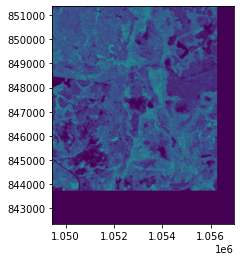

In [115]:
with rio.open('merge/basal_arr_clip_mosaic.vrt') as src:
    show(src)

In [ ]:
'''
Calculation functions:
Functions used to calculate basal, area, leaf-area index, total forested areas, etc., 
by calculating rasters as numpy areas and performing math on them
'''

In [116]:
# Returns array and calculates to the total forested area of pine by adding hardwood and pine bands.
# Returns the percentage of pine or pine out of forested lands'''
def calc_forested_area(landcover_filename, hardwood_band_num, pine_band_num):
    raster = gdal.Open(landcover_filename)
    band_hardwood = raster.GetRasterBand(hardwood_band_num)
    hardwood_nodata_val = band_hardwood.GetNoDataValue()
    #Get no data value of each bands so we can exclude them from our results
    band_pine = raster.GetRasterBand(pine_band_num)
    pine_nodata_val = band_pine.GetNoDataValue()
    hardwood_arr = BandReadAsArray(band_hardwood)
    pine_arr = BandReadAsArray(band_pine)
    #Converted both bands to arrays
    pine_arr = pine_arr.astype('float')
    pine_arr[pine_arr == pine_nodata_val] = np.nan
    hardwood_arr = hardwood_arr.astype('float')
    hardwood_arr[hardwood_arr == hardwood_nodata_val] = np.nan
    #Changed the values of both arrays to float data type so no data values can equal np.nan
    hardwood_pine_arr = hardwood_arr + pine_arr
    #Sum up the hardwood and pine arrays
    hardwood_pine_arr[hardwood_pine_arr == 0] = np.nan
    #So divide by 0 error does not occur. If the sum of both arrays is 0 we know pine is also 0
    percent_pine = pine_arr / hardwood_pine_arr #percentage of pine out of forested bands
    percent_pine_float_32 = percent_pine.astype('float32')
    #change dtype to float 32
    return percent_pine_float_32

In [120]:
percent_pine_of_forested_lands_arr = calc_forested_area('calculations/fl_l1_snip.tif', 4, 6)

In [121]:
percent_pine_of_forested_lands_arr

array([[0.47368422, 0.4477612 , 0.43835616, ..., 0.3148148 , 0.37777779,
        0.36585367],
       [0.45      , 0.46268657, 0.42647058, ..., 0.39130434, 0.41304347,
        0.37777779],
       [0.43548387, 0.42647058, 0.44927537, ..., 0.43636364, 0.48076922,
        0.36363637],
       ...,
       [0.2       , 0.        , 0.25      , ..., 0.25      , 0.25      ,
        0.16666667],
       [0.14285715, 0.33333334, 0.5       , ..., 0.2       , 0.2       ,
        0.16666667],
       [0.2       , 0.5       , 0.75      , ..., 0.14285715, 0.125     ,
        0.125     ]], dtype=float32)

In [122]:
# Returns numpy array of the basal area given to arrays of the same shape
def calc_basal_area(all_baa_array, percent_pine_array):
    basal_area = (all_baa_array * percent_pine_array)
    basal_area_round = np.around(basal_area)
    return basal_area_round

In [127]:
basal_area_arr = calc_basal_area(all_baa_repro_transf, pine_5m_to_10m)

In [128]:
basal_area_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [129]:
array_to_tif(basal_area_arr, 'calculations/basal_area_pine_10m_clip', 'calculations/pine_10m_agg.tif')

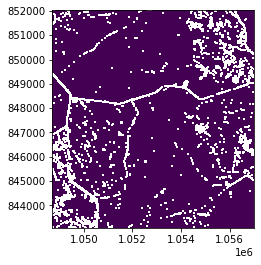

In [130]:
with rio.open('calculations/basal_area_pine_10m_clip.tif') as src:
    show(src)

In [131]:
# Calculates LAI using the formula LAI and basal area
def calc_lai(basal_area_array_or_basal_area_filename, band_num):
    if isinstance(basal_area_array_or_basal_area_filename, np.ndarray):
        lai_pine_arr = basal_area_array_or_basal_area_filename * 0.073 + 0.2671
    else:
        basal_area_ds = gdal.Open(basal_area_array_or_basal_area_filename)
        band = basal_area_ds.GetRasterBand(band_num)
        basal_area_array = BandReadAsArray(band)
        lai_pine_arr = basal_area_array * 0.073 + 0.2671
    return lai_pine_arr

In [132]:
lai_arr = calc_lai(basal_area_arr, 1)

In [147]:
set_nodata_value_of_raster('calculations/depth_to_water_cm_repro_trans_snip.tif', 1, -999)

In [148]:
dtw_arr = reproject_and_transform('calculations/basal_area_pine_10m_clip.tif', 'calculations/depth_to_water_cm_repro_trans_snip.tif', 1)

In [149]:
# Calculates water yield from LAI and depth to water
def calc_water_yield(lai_pine_array, band_num, dtw_filename_or_array):
    if isinstance(dtw_filename_or_array, np.ndarray):
        water_yield_array = (lai_pine_array * -7.97) + (dtw_filename_or_array * -1.95) + (.92 * -335.16) + 393.2
        water_yield_array = np.around(water_yield_array, 3)
    else:
        dtw_array = tif_to_array(dtw_filename_or_array, band_num)
        water_yield_array = (lai_pine_array * -7.97) + (dtw_array * -1.95) + (.92 * -335.16) + 393.2
        water_yield_array = np.around(water_yield_array, 3)
    return water_yield_array

In [150]:
water_yield = calc_water_yield(lai_arr, 1, dtw_arr)

In [151]:
water_yield

array([[-909.137, -913.417, -928.981, ...,  -31.491,  -44.424,  -34.532],
       [-909.919, -906.173, -906.006, ...,  -36.025,  -30.306,  -21.626],
       [-926.205, -895.85 , -915.533, ...,  -74.226,  -70.148,  -66.578],
       ...,
       [-934.794, -877.876, -853.8  , ..., -430.938, -414.043, -422.349],
       [-992.861, -888.467, -851.689, ..., -413.614, -405.818, -424.847],
       [-925.16 , -926.711, -878.639, ..., -399.873, -421.02 , -393.094]],
      dtype=float32)

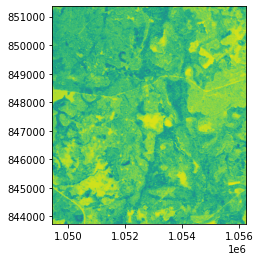

In [153]:
with rio.open('water_yield_raster_snip.tif') as src:
    show(src)

In [ ]:
'''Basal area scenarios'''

In [158]:
#Change basal area of value of pine that are greater than or equal to desired values
def change_basal_area_vals(basal_area_arr, value_to_change_to):
    basal_area_arr_2 = basal_area_arr.copy()
    basal_area_arr_2[basal_area_arr_2 > value_to_change_to] = value_to_change_to
    return basal_area_arr_2

In [159]:
basal_area_18 = change_basal_area_vals(basal_area_arr, 18)
basal_area_18

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [155]:
#Calculates potential water yield gain based ont the basal area scenarios
def potential_water_yield_gain(water_yield_current_level_arr, water_yield_scenario_arr):
    water_yield_gain_potential_arr = water_yield_scenario_arr - water_yield_current_level_arr
    return water_yield_gain_potential_arr

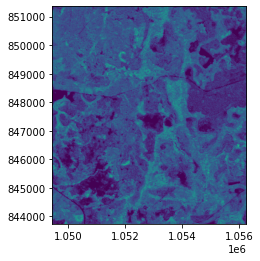

In [157]:
with rio.open('water_yield_gain_18_snip.tif') as src:
    show(src)